## Importy

In [ ]:
import numpy as np
from scipy.linalg import norm, hilbert, eig, solve, invs
import time
import tracemalloc
import matplotlib.pyplot as plt

# Funkcje z listy 2, które zostaną wykorzystane w zadaniach

In [3]:
def gauss(matrix):
    n = matrix.shape[0]
    for i in range(n):
        max_row = np.argmax(np.abs(matrix[i:, i])) + i

        if max_row != i:
            matrix[[i, max_row]] = matrix[[max_row, i]]

        for j in range(i + 1, n):
            ratio = matrix[j, i] / matrix[i, i]
            matrix[j] -= ratio * matrix[i]
    
    return matrix

In [4]:
def solution(A, b):
    matrix = np.hstack([A, b.reshape(-1, 1)])
    gauss(matrix)
    n = matrix.shape[0]
    x = np.zeros(n)
    
    for i in range(n - 1, -1, -1):
        x[i] = (matrix[i, -1] - np.dot(matrix[i, i + 1:n], x[i + 1:n])) / matrix[i, i]
    
    return x

In [5]:
def determinant(A):
    n = A.shape[0]
    det = 1
    row_swaps = 0  
    
    for i in range(n):
        max_row = np.argmax(np.abs(A[i:, i])) + i

        if max_row != i:
            A[[i, max_row]] = A[[max_row, i]]
            row_swaps += 1  
        
        if A[i, i] == 0:
            return 0

        for j in range(i + 1, n):
            ratio = A[j, i] / A[i, i]
            A[j] -= ratio * A[i]

    for i in range(n):
        det *= A[i, i]

    if row_swaps % 2 == 1:
        det *= -1  
    
    return det

In [6]:
def inverse(A):
    if determinant(A) == 0:
        raise ValueError('Macierz osobliwa, nie ma macierzy odwrotnej')
    n = A.shape[0]
    A = np.hstack([A, np.eye(n)])
    
    for i in range(n):
        max_row = np.argmax(np.abs(A[i:, i])) + i
        
        if max_row != i:
            A[[i, max_row]] = A[[max_row, i]]
        
        A[i] /= A[i, i]

        for j in range(n):
            if j != i:
                A[j] -= A[i] * A[j, i]

    A_inv = A[:, n:]
    
    return A_inv

___
# Zadanie 1
Funkcja `Lu(A)` dokonuje dekompozycji macierzy kwadratowej $ A $ na macierze dolnotrójkątną $ L $ oraz macierzy górnotrójkątną $ U $, takich że $ A = L \cdot U $. Macierz $ L $ posiada jedynki na diagonali, a $ U $ zawiera elementy na i nad główną przekątną. Funkcja iteracyjnie oblicza elementy $ L $ i $ U $, używając sum częściowych dla każdego elementu. Jeśli macierz $ A $ jest osobliwa, funkcja zgłasza błąd.

In [7]:
def Lu(A):
    A = np.array(A)
    n = A.shape[0]
    L = np.zeros_like(A)
    U = np.zeros_like(A)

    for i in range(n):
        for k in range(i, n):
            L_sum = sum(L[i][j] * U[j][k] for j in range(i))
            U[i][k] = A[i][k] - L_sum

        for k in range(i, n):
            if i == k:
                L[i][i] = 1.0  
            else:
                U_sum = sum(L[k][j] * U[j][i] for j in range(i))
                if U[i][i] == 0:
                    raise ValueError('Macierz osobliwa, nie może zostać rozłożona na LU.')
                L[k][i] = (A[k][i] - U_sum) / U[i][i]

    return L, U


Zaimplementowana funkcja `iterative_refinement(A, b, u, max_iter)` w pojedynczej precyzji iteracyjnie poprawia rozwiązanie układu równań. Najpierw oblicza początkowe rozwiązanie za pomocą rozkładu LU, który jest obliczany za pomocą funckcji `Lu(A)`  a następnie iteracyjnie koryguje $x$ wykorzystując resztę $r = b - Ax$. Proces kończy się, gdy norma reszty jest mniejsza niż norma pomnożonej macierzy A przez wektor $\vec{x}$ pomnożonej przez $u$, wektora $\vec{b}$ pomnożonego przez $u$, gdzie $u$ jest jednostką maszynową lub osiągnięty zostanie limit iteracji.

In [9]:
def iterative_refinement(A, b, u=1e-16, max_iterations=10000):
    A = A.astype(np.float32)
    b = b.astype(np.float32)
    L,U = Lu(A)
    L = L.astype(np.float32)
    U = U.astype(np.float32)
    y = solution(L, b).astype(np.float32)
    x = solution(U, y).astype(np.float32)

    r = b - np.dot(A, x)
    r = r.astype(np.float32)
    
    for _ in range(max_iterations):
        if norm(r,np.inf) > norm(np.dot(A,x), np.inf) * u or norm(r) > norm(b) * u:
            delta_x = solution(A, r).astype(np.float32)
            x += delta_x
            x = x.astype(np.float32)
            r = b - np.dot(A, x)
            r = r.astype(np.float32)
        else:
            break
            
    return x

A = hilbert(5) 
b = np.array([5, 4, 3, 2, 1])

solution_x= iterative_refinement(A, b)
print(f'Rozwiązanie x: {solution_x}')

Rozwiązanie x: [   -94.87707   2157.6807  -10699.923    17904.705    -9442.492  ]


___
# Zadanie 2

Funkcja `LDU(A)` rozkłada macierz $ A $ na trzy macierze: $ L $ (dolna), $ D $ (diagonalna) i $ U $ (górna). Macierz $ L $ zawiera elementy poniżej diagonali, $ D $ elementy na diagonali, a $ U $ elementy powyżej diagonali. Na końcu zwraca te macierze, których suma daje oryginalną macierz $ A $.

In [10]:
def LDU(A):
    n = A.shape[0]
    L = np.zeros_like(A, dtype=float) 
    D = np.zeros_like(A, dtype=float) 
    U = np.zeros_like(A, dtype=float) 
    for i in range(n):
        for j in range(n):
            if i > j:
                L[i, j] = A[i, j]
            elif i == j:
                D[i, j] = A[i, j] 
            elif i < j:
                U[i, j] = A[i, j]  

    return L, D, U

Funkcja `create_matrix_vector(n)` generuje zadaną macierz $A$ i wektor $\vec{b}$.

In [11]:
def create_matrix_vector(n):
    A = np.zeros((n, n), dtype=float)
    
    for i in range(n):
        A[i, i] = 4  
        
        if i > 0:
            A[i, i-1] = -1  
        
        if i < n-1:
            A[i, i+1] = -1 

    A[0, -1] = 1
    A[-1, 0] = 1

    B = np.zeros(n, dtype=float)
    B[-1] = 100
    
    return A, B

Funkcja `gauss_seidel(A, b)` iteracyjnie rozwiązuje układ $Ax = b$, najpierw sprawdzając, czy macierz $A$ spełnia warunek zbieżności poprzez obliczenie promienia spektralnego macierzy $M_{GS}$. Następnie macierz $A$ jest dekomponowana na części $D$, $L$ i $U$, a $M_{GS}$ oraz wektor $x_0$ są wykorzystywane do iteracyjnego obliczania kolejnych przybliżeń $x$. Proces trwa, dopóki norma różnicy między kolejnymi przybliżeniami nie osiągnie zadanej tolerancji lub nie zostanie osiągnięty limit iteracji.

In [12]:
A, b = create_matrix_vector(20)

def check_convergence(A):
    L,D,U = LDU(A)
    
    N = inverse(D + L)
    M_gs = np.dot(-N, U)

    eigenvalues= eig(M_gs)[0]
    spectral_radius = max(abs(eigenvalues))
    
    return spectral_radius <=1

def gauss_seidel(A, b, error = 1e-16, max_iter = 1000):
    if not check_convergence(A):
        raise ValueError('Macierz nie spełnia warunku zbieżności.')
    n = len(b)
    L,D,U = LDU(A)
    N = inv(D + L)
    M_gs = np.dot(-N, U)
    x_0 = np.zeros(n)
    x = np.dot(M_gs, x_0) + np.dot(N, b)

    i = 0
    while norm(x-x_0, np.inf) > error:
        i +=1 
        if i>= max_iter:
            print('Nie osiągnięto zbieżności w limicie iteracji')
            break
        x_0 = x
        x = np.dot(M_gs, x_0) + np.dot(N, b)
    return x

solution = gauss_seidel(A, b)
print(f'Rozwiązanie x:\n {solution}')


Rozwiązanie x:
 [-7.73502692e+00 -2.07259421e+00 -5.55349941e-01 -1.48805549e-01
 -3.98722562e-02 -1.06834753e-02 -2.86164518e-03 -7.63105381e-04
 -1.90776345e-04  4.91956736e-18  1.90776345e-04  7.63105381e-04
  2.86164518e-03  1.06834753e-02  3.98722562e-02  1.48805549e-01
  5.55349941e-01  2.07259421e+00  7.73502692e+00  2.88675135e+01]


___
# Zadanie 3

Kod mierzy czas wykonania metody Gaussa-Seidla oraz wbudowanej funkcji `scipy.linalg.solve`, a także analizuje zużycie pamięci przez obie metody za pomocą `tracemalloc`. Wyniki obejmują czas wykonania oraz bieżące i maksymalne zużycie pamięci w MB, co pozwala porównać wydajność obu podejść pod kątem szybkości i pamięciożerności.

In [13]:
start1 = time.time()
solution = gauss_seidel(A, b)
stop1 = time.time()
time_gauss_seidel = stop1 - start1

start2 = time.time()
x_scipy = solve(A,b)
end2 = time.time()
time_scipy_solve = end2 - start2

print(f'Rozwiązanie uzyskane za pomocą metody zaimplementowanej w scipy: \n{x_scipy}')
print(f'\nCzas wykonywania metodą Gaussa-Seidela: {time_gauss_seidel:.9f}, \nCzas wykonywania metodą zaimplementowaną w scipy: {time_scipy_solve:.9f}')

Rozwiązanie uzyskane za pomocą metody zaimplementowanej w scipy: 
[-7.73502692e+00 -2.07259421e+00 -5.55349941e-01 -1.48805549e-01
 -3.98722562e-02 -1.06834753e-02 -2.86164518e-03 -7.63105381e-04
 -1.90776345e-04 -3.63138871e-20  1.90776345e-04  7.63105381e-04
  2.86164518e-03  1.06834753e-02  3.98722562e-02  1.48805549e-01
  5.55349941e-01  2.07259421e+00  7.73502692e+00  2.88675135e+01]

Czas wykonywania metodą Gaussa-Seidela: 0.006367207, 
Czas wykonywania metodą zaimplementowaną w scipy: 0.000499725


In [73]:
tracemalloc.start()
solve(A, b)
current, peak = tracemalloc.get_traced_memory()
print(f'scipy.linalg.solve zużycie pamięci: {current / 10**6:.6f} MB, peak: {peak / 10**6:.6f} MB')
tracemalloc.stop()

tracemalloc.start()
gauss_seidel(A, b)
current, peak = tracemalloc.get_traced_memory()
print(f'gauss_seidel zużycie pamięci: {current / 10**6:.6f} MB, peak: {peak / 10**6:.6f} MB')
tracemalloc.stop()

scipy.linalg.solve zużycie pamięci: 0.000969 MB, peak: 0.021179 MB
gauss_seidel zużycie pamięci: 0.002482 MB, peak: 0.063946 MB


Korzystając z uzyskanych danych możemy stwierdzić, że dla zadanego układu równań, metoda scipy jest bardziej optymalna od metody Gaussa- Seidla. Taka sytuacja może być spowodowana tym, że zadany układ równań wolno zbiega do swojego rozwiązania, a metoda wbudowana w scipy jest szybka dla niewielkich układów równań. W teorii metoda wbudowana w scipy ma złożoność $O(n^3)$ dla każdej macierzy. Metoda Gaussa- Seidla ma natomiast złożoność $O(k \cdot n^2)$, gdzie $k$ to liczba iteracji, więc jest niewiększa niż złożoność wbudowanej w scipy metody.  

___
# Zadanie 4
Kod generuje macierz $A$ o zadanej wielkości $n$ z wartościami na głównej diagonali rosnącymi o 0.025, oraz wartościami 5 na górnej diagonali. Następnie iteracyjnie oblicza $x^{(k)} = A \cdot x^{(k-1)}$, gdzie $x^{(0)}$ jest wektorem jedynek. Dla każdej iteracji oblicza się wartość $\eta_k = \frac{||x^{(k)}||_2}{||x^{(0)}||_2}$, rejestrując jej zmiany dla kolejnych wartości $k$. 

Wykres pokazuje, jak wartość $\eta_k$ zmienia się w kolejnych iteracjach, zaznaczając indeks $k$, w którym $\eta_k$ osiąga swoje maksimum. Na końcu program wypisuje najmniejsze $k$, dla którego norma $x^{(k)}$ jest mniejsza niż norma wektora $x^{(0)}$.

In [14]:
def create_matrix(n=20):
    main_diagonal = np.arange(0.025,0.525,0.025)

    upper_diagonal = np.full(n - 1, 5.0)
    
    A = np.zeros((n, n),dtype=float)
    
    np.fill_diagonal(A, main_diagonal)
    
    np.fill_diagonal(A[:, 1:], upper_diagonal)
    
    return A

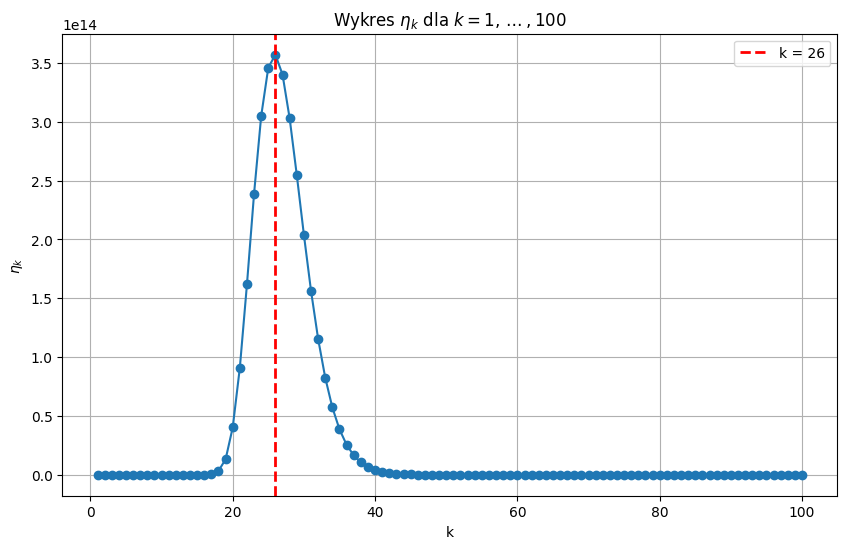

Najmniejsze k, dla którego ||x^(k)|| < ||x^(0)|| to k = 86


In [15]:
n = 20
num_iterations = 100

A = create_matrix(n)
x = np.ones(n)
eta_values = []

norm_x0 = norm(x,2)
k_values = []

for k in range(1,num_iterations+1):
    x = np.dot(A,x) 
    if norm(x,2) < norm_x0:
        k_values.append(k)
    eta_k = norm(x,2) / norm_x0  
    eta_values.append(eta_k)

k_min = np.min(k_values)

maximum_eta_index = eta_values.index(max(eta_values)) + 1

plt.figure(figsize = (10,6))
plt.plot(range(1, num_iterations + 1), eta_values, marker='o')
plt.xlabel('k')
plt.ylabel(r'$\eta_k$')
plt.title(r'Wykres $\eta_k$ dla $k = 1, \dots, 100$')
plt.axvline(maximum_eta_index, color = 'red', linestyle = '--', linewidth = 2, label = f'k = {maximum_eta_index}')
plt.grid(True)
plt.legend()
plt.show()

print(f'Najmniejsze k, dla którego ||x^(k)|| < ||x^(0)|| to k = {k_min}')


Możemy zauważyć, że początkowo $\eta_k > 10^{14}$ i osiąga swoje maksimum dla $k = 26$, a następnie maleje. Najmniejszym $k$, dla którego $||x^{(k)}||_2 < ||x^{(0)}||_2$ to $k = 86$.